In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [3]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.special import softmax

import torch
import torch.nn.functional as F
from fast_pytorch_kmeans import KMeans
from transformers import AutoTokenizer, AutoModel

from misc.local_utils import get_phrase_embedding, get_sentence_embedding
from utils.viz import bokeh_2d_scatter, bokeh_2d_scatter_new
from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load datasets

In [37]:
datasets = [
    {
        "name": "Kinetics",
        "key": "Kinetics-400",
        "args": {"data_dir": "../../data/Kinetics-400/"},
        "color": "limegreen",
        "filename": "kinetics_400_labels.csv",
    },
    {
        "name": "UCF",
        "key": "UCF-101",
        "args": {"data_dir": "../../data/UCF-101/"},
        "color": "red",
        "filename": "classes_cleaned.txt",
    },
    {
        "name": "NTU",
        "key": "NTU-60",
        "args": {"data_dir": "../../data/NTU/"},
        "color": "blue",
        "filename": "class_labels_ntu60.txt",
    },
    {
        "name": "SomethingSomething",
        "key": "SS(V2)-174",
        "args": {"data_dir": "../../data/Something-Something/"},
        "color": "yellow",
        "filename": "fine_grained_classes_cleaned.csv",
    },
    {
        "name": "FineGym",
        "key": "FineGym-99",
        "args": {"data_dir": "../../data/FineGym/"},
        "color": "gray",
        "filename": "gym99_categories_cleaned.txt",
    },
    {
        "name": "EPIC",
        "key": "EPIC-Verbs",
        "args": {"data_dir": "../../data/EPIC-KITCHENS-100/"},
        "color": "magenta",
        "filename": "EPIC_100_verb_classes.csv",
    },
    {
        "name": "EPIC",
        "key": "EPIC-Nouns",
        "args": {"data_dir": "../../data/EPIC-KITCHENS-100/"},
        "color": "purple",
        "filename": "EPIC_100_noun_classes.csv",
    },
]

In [38]:
# load class labels per dataset
dataset_action_labels = dict()

for i, dataset_args in enumerate(datasets):
    dataset = eval(f"{dataset_args['name']}(**{dataset_args['args']})")
    class_label_dict = dataset._load_annotations(filename=dataset_args["filename"])
    
    key = dataset_args.get("key", dataset_args['name'])
    dataset_action_labels[key] = class_label_dict

In [39]:
dataset_action_labels.keys()

dict_keys(['Kinetics-400', 'UCF-101', 'NTU-60', 'SS(V2)-174', 'FineGym-99', 'EPIC-Verbs', 'EPIC-Nouns'])

### Get action class embeddings

In [40]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
dataset_action_embeddings = dict()

for dataset, action_labels in dataset_action_labels.items():
    iterator = tqdm(
        action_labels.items(),
        desc=f"Extracting BERT embeddings for {dataset}\t",
        bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
    )
    dataset_action_embeddings[dataset] = {
        k: get_sentence_embedding(model, tokenizer, v) \
        for k, v in iterator
    }

Extracting BERT embeddings for EPIC-Nouns	: 100%|██████████| 300/300 [00:21<00:00, 14.16it/s]                                                               


In [42]:
dataset_action_embeddings.keys()

dict_keys(['Kinetics-400', 'UCF-101', 'NTU-60', 'SS(V2)-174', 'FineGym-99', 'EPIC-Verbs', 'EPIC-Nouns'])

In [43]:
assert set(dataset_action_embeddings.keys()) == set(dataset_action_labels.keys())

### Visualize embeddings

In [44]:
dfs = []
all_embeddings = []

for datadict in datasets:
    local_df = pd.DataFrame(None)
    
    class_embeddings = dataset_action_embeddings[datadict["key"]]
    class_embeddings = torch.stack(list(class_embeddings.values()))
    action_labels = dataset_action_labels[datadict["key"]]
    
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = datadict["color"]
    local_df["dataset"] = datadict["key"]
    dfs.append(local_df)
    
    all_embeddings.append(class_embeddings)

In [45]:
embeddings = torch.cat(all_embeddings)
(U, S, V) = torch.pca_lowrank(embeddings)

K = 2

all_dimreds = []
dataset_action_latents = dict()

for i, X in enumerate(all_embeddings):
    Z = torch.matmul(X, V[:, :K])

    dataset_action_latents[datasets[i]["key"]] = {dfs[i].loc[j, "class_id"]: Z[j] for j in range(Z.shape[0])}
    
    try:
        dfs[i]["Z1"] = Z[:, 0]
        dfs[i]["Z2"] = Z[:, 1]
    except:
        import ipdb; ipdb.set_trace()

In [46]:
all_df = pd.concat(dfs)

In [47]:
all_df.head().shape

(5, 6)

In [48]:
all_df.head()

,class_id,class_label,color,dataset,Z1,Z2
0,0,abseiling,limegreen,Kinetics-400,3.602618,3.259799
1,1,air drumming,limegreen,Kinetics-400,1.393425,3.026237
2,2,answering questions,limegreen,Kinetics-400,3.538200,5.524848
3,3,applauding,limegreen,Kinetics-400,3.223112,5.008060
4,4,applying cream,limegreen,Kinetics-400,3.410736,3.409169


In [50]:
bokeh_2d_scatter_new(
    df=all_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="BERT-based embeddings for action classes (phrases) in various datasets.", legend_loc="top_right",
)

Loading BokehJS ...

### Computer cluster means and variances

In [51]:
dataset_action_embeddings.keys()

dict_keys(['Kinetics-400', 'UCF-101', 'NTU-60', 'SS(V2)-174', 'FineGym-99', 'EPIC-Verbs', 'EPIC-Nouns'])

In [52]:
normalize=False

means = dict()

for key in dataset_action_embeddings:
    embeddings = torch.stack(list(dataset_action_embeddings[key].values()))
    
    means[key] = embeddings.mean(dim=0)

    embeddings -= embeddings.mean(dim=0)
    # print(f"Mean of {key}: \t", embeddings.mean(dim=0))
    

    if normalize:
        norm = torch.norm(embeddings, dim=1)
        embeddings = torch.div(embeddings.T, norm).T
    
    print(f"Variance in {key}: \t", torch.std(embeddings, axis=0).mean())

Variance in Kinetics-400: 	 tensor(0.1895)
Variance in UCF-101: 	 tensor(0.1943)
Variance in NTU-60: 	 tensor(0.1727)
Variance in SS(V2)-174: 	 tensor(0.1185)
Variance in FineGym-99: 	 tensor(0.1387)
Variance in EPIC-Verbs: 	 tensor(0.1686)
Variance in EPIC-Nouns: 	 tensor(0.1720)


In [53]:
df = pd.DataFrame(None, index=means.keys(), columns=means.keys())
for key1 in means.keys():
    for key2 in means.keys():
        df.loc[key1, key2] = torch.cdist(
            means[key1].unsqueeze(0),
            means[key2].unsqueeze(0),
        ).numpy()[0][0].astype(float)

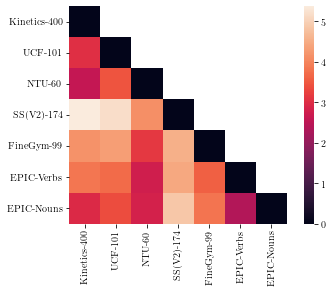

In [54]:
corr= df.values

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)


sns.heatmap(df.astype(float), square=True, mask=matrix)
plt.show()

### Visualize similarity between pair of datasets

In [55]:
def compute_label_similarity(source: dict, target: dict, threshold: float = 0.1, subtract_mean=False):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    if subtract_mean:
        source_embeddings -= source_embeddings.mean(dim=0)

    target_embeddings = torch.stack([v for k, v in target.items()])
    if subtract_mean:
        target_embeddings -= target_embeddings.mean(dim=0)

    for i in range(len(source_embeddings)):
        df.iloc[i] = F.cosine_similarity(target_embeddings, source_embeddings[[i], :]).numpy()
    
    return df

In [56]:
def compute_label_distance(source: dict, target: dict, threshold: float = 0.1, p=1, subtract_mean=False):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    if subtract_mean:
        source_embeddings -= source_embeddings.mean(dim=0)

    target_embeddings = torch.stack([v for k, v in target.items()])
    if subtract_mean:
        target_embeddings -= target_embeddings.mean(dim=0)
    
    for i in range(len(source_embeddings)):
        df.iloc[i] = F.pairwise_distance(target_embeddings, source_embeddings[[i], :], p=p).numpy()
    
    return df

In [57]:
def compute_metric_per_dataset(dataset, metric=compute_label_similarity, subtract_mean=False, normalize=True):
    
    embeddings = dataset_action_embeddings[dataset]

    df = metric(embeddings, embeddings, subtract_mean=subtract_mean)
    df = df.rename(columns=dataset_action_labels[dataset], index=dataset_action_labels[dataset])

    if normalize:
        df = (df - df.min()) / (df.max() - df.min())

    return df

In [58]:
def compute_metric_between_datasets(
        source, target, metric=compute_label_similarity, subtract_mean=False, normalize=False,
    ):
    
    source_embeddings = dataset_action_embeddings[source]
    target_embeddings = dataset_action_embeddings[target]

    df = metric(source_embeddings, target_embeddings, subtract_mean=subtract_mean)
    df = df.rename(columns=dataset_action_labels[source], index=dataset_action_labels[target])
    
    if normalize:
        df = (df - df.min()) / (df.max() - df.min())

    return df

In [59]:
def heatmap(df, figsize=(10, 10), ax=None, **kwargs):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    if "cmap" not in kwargs:
        kwargs.update(cmap="Blues")
    sns.heatmap(df, ax=ax, vmin=0.0, vmax=1.0, **kwargs)
    plt.show()

In [60]:
def plot_cross_dataset_similarity(
        source: str, target: str, threshold: float = 0.4,
        subtract_mean=True, normalize=False, plot_all=False,
        show_heatmap=True,
    ):

    source_X = dataset_action_embeddings[source]
    source_y = dataset_action_labels[source]
    source_X = {"S-" + source_y[k]:v for k, v in source_X.items()}

    target_X = dataset_action_embeddings[target]
    target_y = dataset_action_labels[target]
    target_X = {"T-" + target_y[k]:v for k, v in target_X.items()}

    combined_X = {**source_X, **target_X}

    df = compute_label_similarity(combined_X, combined_X, subtract_mean=subtract_mean)

    if normalize:
        df = (df - df.min())/(df.max() - df.min())

    if not plot_all:
        # retain source labels as rows and target labels as columns
        df = df.drop(
            columns=["S-" + x for x in list(source_y.values())],
            index=["T-" + x for x in list(target_y.values())],
        )
    
    if show_heatmap:
        heatmap(df, cmap="YlGnBu")
    
    overlap = sum(df.max(axis=0) > threshold) / df.shape[1]
    # overlap = df.sum().mean()
    # overlap = 
    
    return df, overlap

In [62]:
results = pd.DataFrame(None, index=[0], columns=dataset_action_embeddings.keys())

for dataset in dataset_action_embeddings:
    df, overlap = plot_cross_dataset_similarity("Kinetics-400", dataset, show_heatmap=False, threshold=0.4)
    results.loc[0, dataset] = overlap

In [63]:
results

,Kinetics-400,UCF-101,NTU-60,SS(V2)-174,FineGym-99,EPIC-Verbs,EPIC-Nouns
0,1.0,0.693069,0.716667,0.764368,0.651685,0.845361,0.436667


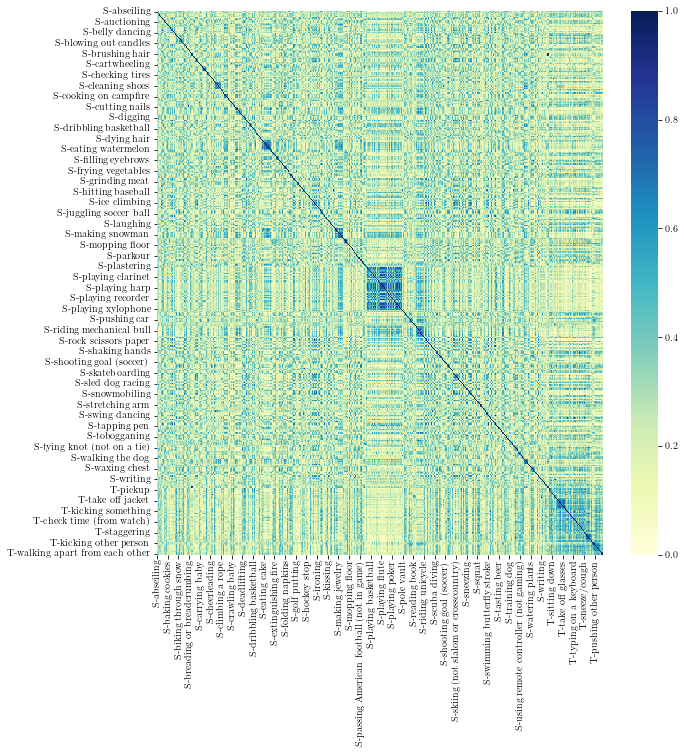

In [64]:
df, overlap = plot_cross_dataset_similarity("Kinetics-400", "NTU-60", normalize=True, plot_all=True)

### Visualize embeddings per dataset

In [65]:
def plot_dataset_embeddings(dataset_name, action_labels, embeddings_dict, color="blue", K=2, plot=True, return_df=False):
    embeddings = torch.stack(list(embeddings_dict.values()))
    (U, S, V) = torch.pca_lowrank(embeddings)
    Z = torch.matmul(embeddings, V[:, :K])

    local_df = pd.DataFrame(None)
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = color
    local_df["dataset"] = dataset_name
    local_df["Z1"] = Z[:, 0]
    local_df["Z2"] = Z[:, 1]
    
    if plot:
        bokeh_2d_scatter_new(
            df=local_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
            title=f"BERT-based embeddings for action classes (phrases) in {dataset_name}.", legend_loc="top_right",
        )
    
    if return_df:
        return local_df

For each class label, we find if there exists at least 1 "highly similar" class. Similarity is defined by cosine similarity and highness is defined by a threshold=0.7. We roughly manually labelled UCF and NTU and we found 30 actions which were in pairs and 20 which had atleast one close neighbor for NTU.

We can define "extrovert" classes as $|\mathcal{E}_{\mathcal{L}}| / |\mathcal{L}|$ where

$$\mathcal{E}_{\mathcal{L}} = \{i \in \mathcal{L}: |N_{i}| >= 1\}$$
$$N_i = \{j \in \mathcal{L} - \{i\} : d(i, j) > \tau \}$$

where $N_i$ can be thought of as a "close" neighborhood around class $i$.

In [74]:
def fraction_of_extrovert_classes(df, threshold=0.8, K=1):

    # N(i) = number of classes {j} that are "highly close" to class i (neighborhood of i)
    # metric = |{i such that |N(i)| >= K}|

    isolated_i = []

    for i in range(df.shape[1]):
        Ni = [j for j in range(df.shape[0]) if df.iloc[j, i] > threshold]
        if len(Ni) >= K:
            isolated_i.append(i)

    fraction = len(isolated_i) / df.shape[1]
    
    return fraction

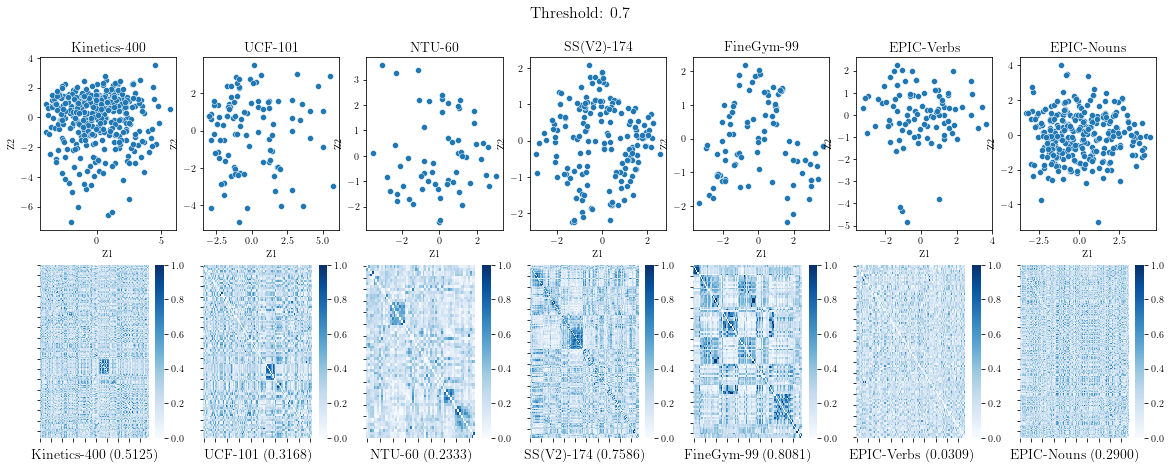

In [75]:
fig, ax = plt.subplots(2, len(dataset_action_embeddings), figsize=(20, 7))

all_dfs = dict()

i = 0
for dataset in dataset_action_embeddings.keys():
    # print(f"Dataset: {dataset}")

    # plot the embeddings
    idx = [x["key"] for x in datasets].index(dataset)
    color = datasets[idx]["color"]
    latent_df = plot_dataset_embeddings(
        dataset, dataset_action_labels[dataset], dataset_action_embeddings[dataset],
        return_df=True, plot=False,
    )
    latent_df["Z1"] = latent_df["Z1"] - latent_df["Z1"].mean()
    latent_df["Z2"] = latent_df["Z2"] - latent_df["Z2"].mean()
    sns.scatterplot(data=latent_df, x="Z1", y="Z2", ax=ax[0, i])
    ax[0, i].set_title(f"{dataset}", fontsize=14)
    # plot_dataset_embeddings(dataset, dataset_action_labels[dataset], dataset_action_embeddings[dataset])
    
    # plot the similarity matrix
    df = compute_metric_per_dataset(dataset, subtract_mean=True, normalize=True)
    all_dfs[dataset] = df
    
    # compute intra-dataset variance
    # df = df[df > 0.2]
    # df = df.fillna(0.0)
    
    # make diagonal entries 0
    sim_mat = df.values
    sim_mat[range(sim_mat.shape[0]), range(sim_mat.shape[0])] = 0.0

    # heatmap(df)
    threshold=0.7
    dataset_variance = fraction_of_extrovert_classes(df, threshold=threshold, K=1)

    df.columns = [''] * len(df.columns)
    df.index = [''] * len(df.index)

    sns.heatmap(df, ax=ax[1, i], vmin=0.0, vmax=1.0, cmap="Blues")
    ax[1, i].set_xlabel(f"{dataset} ({dataset_variance:.4f})", fontsize=14)
    
    i += 1

plt.suptitle(f"Threshold: {threshold}", fontsize=16)
plt.savefig("../../results/plots/intra_dataset_similarity-scatter_and_heatmap_all.pdf", bbox_inches="tight")
plt.show()

##### Plot fraction of extrovert points as a function of threshold

In [76]:
thresholds = np.linspace(0.0, 1.0, 20)

extrovert_fraction = defaultdict(list)
for threshold in tqdm(thresholds):
    for dataset, df in all_dfs.items():
        extrovert_fraction[dataset].append(fraction_of_extrovert_classes(df, threshold, K=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  3.01s/it]


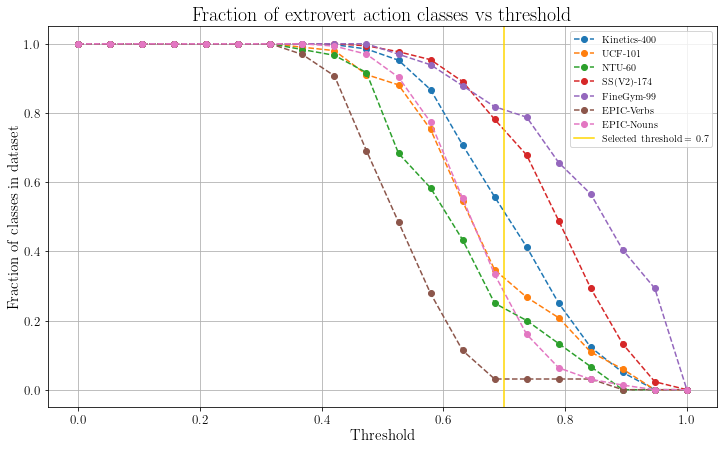

In [71]:
titlesize=20
labelsize=15
tickssize=13

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for dataset, values in extrovert_fraction.items():
    ax.plot(thresholds, values, "--o", label=dataset)

ax.axvline(x=0.7, label="Selected threshold = 0.7", c="gold")
ax.grid()
ax.legend()
ax.set_title("Fraction of extrovert action classes vs threshold", fontsize=titlesize)
ax.set_xlabel("Threshold", fontsize=labelsize)
ax.set_ylabel("Fraction of classes in dataset", fontsize=labelsize)

ax.tick_params(axis="x", labelsize=tickssize)
ax.tick_params(axis="y", labelsize=tickssize)

plt.savefig(
    "../../results/plots/intra_dataset_similarity-extrovert_fraction_vs_threshold-all.pdf",
    bbox_inches="tight",
)
plt.show()

#### Compute distribution of scores

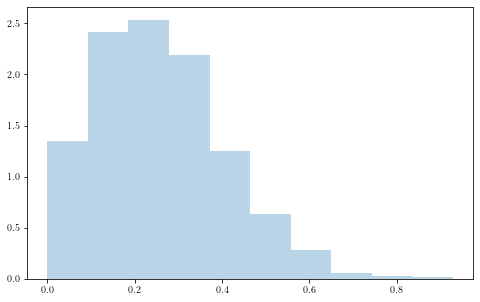

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for dataset, df in all_dfs.items():
    if dataset == "UCF-101":
        ax.hist(df.values.reshape(len(df) * len(df)), density=True, alpha=0.3)